In [1]:
import pandas as pd
import numpy as np 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error

import seaborn as sns
sns.set(rc={"figure.figsize": (20, 10)})

In [2]:
PATH = "../dados/brutos/HIST_PAINEL_COVIDBR_20mai2020.xlsx"

In [3]:
corona_df = pd.read_excel(PATH)
corona_df["data"] = pd.to_datetime(corona_df["data"])
brasil_df = corona_df[corona_df["regiao"] == "Brasil"]

In [4]:
data_df = brasil_df[["casosAcumulado"]]
data_df.columns = ["casos"]

In [5]:
data_df.tail()

,casos
80,233142
81,241080
82,254220
83,271628
84,291579


# Casos acumulados

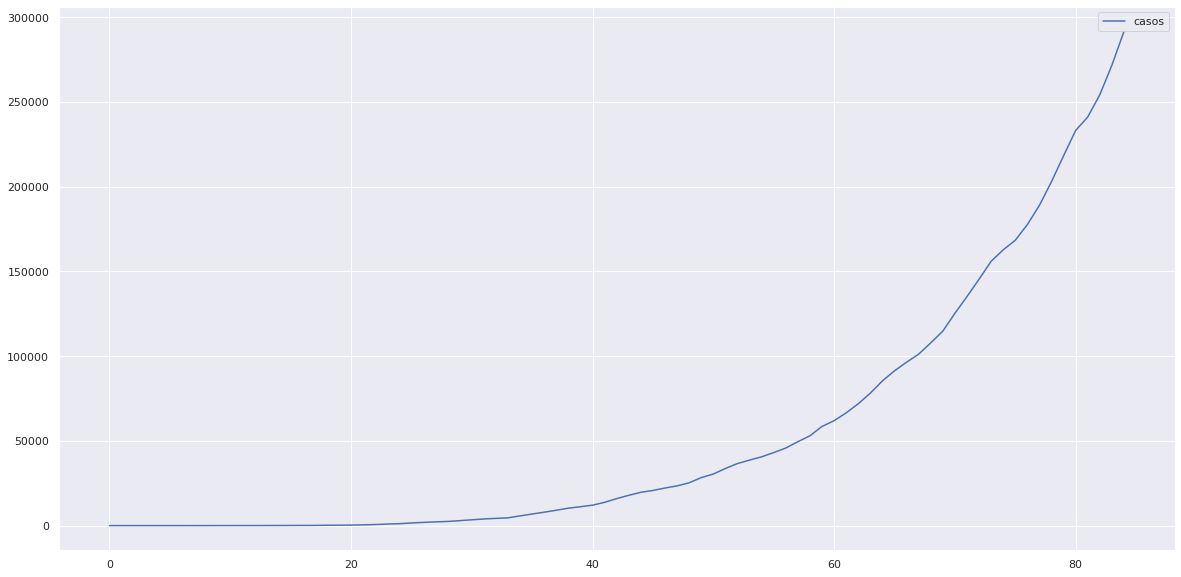

In [6]:
data_df.plot()

# Casos cumulados em escala logarítimica

In [7]:
# Limitando para iniciar no dia do primeiro caso, necessário para que o log esteja definido
# data_df = data_df[data_df["casos"] >= 1]

In [8]:
data_df["log_casos"] = np.log10(data_df["casos"])
data_df.replace([-np.inf], 0, inplace=True)
data_df["index"] = [i for i in range(len(data_df))]

In [9]:
data_df

,casos,log_casos,index
0,1,0.000000,0
1,1,0.000000,1
2,1,0.000000,2
3,2,0.301030,3
4,2,0.301030,4
...,...,...,...
80,233142,5.367621,80
81,241080,5.382161,81
82,254220,5.405210,82
83,271628,5.433975,83


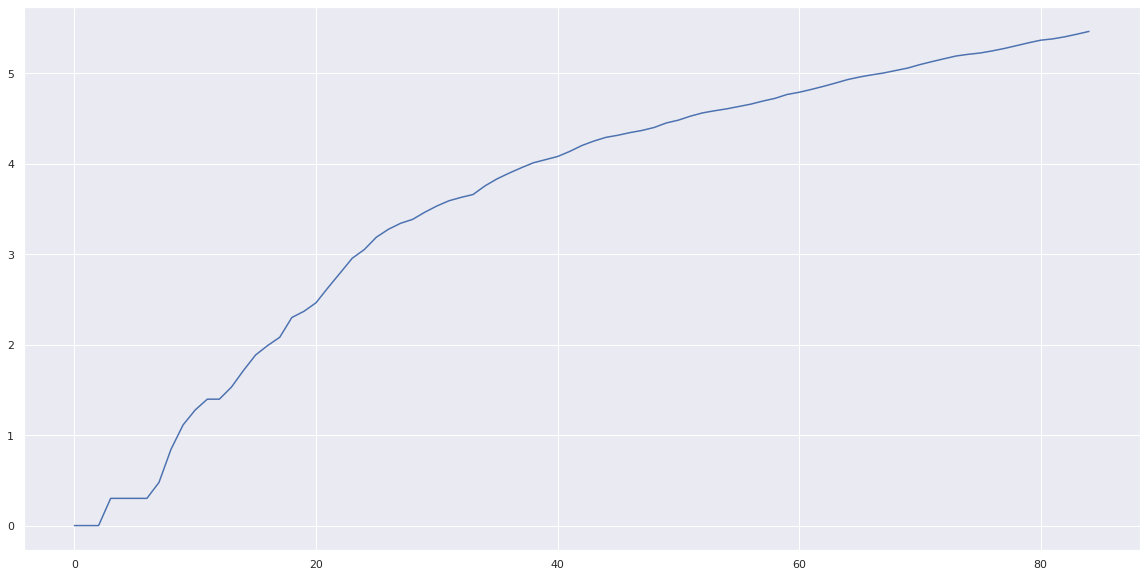

In [10]:
data_df["log_casos"].plot()

# Predições utilizando regressão linear

In [11]:
prediction_window = 10 # dias

In [12]:
x = data_df["index"].values.reshape(-1, 1)
y = data_df["log_casos"].values

In [13]:
regressor = LinearRegression()

In [14]:
preds = cross_val_predict(regressor, x, y, cv=10)
data_df["preds"] = preds

In [15]:
data_df.tail(15)

,casos,log_casos,index,preds
70,125218,5.097667,70,5.458311
71,135106,5.130675,71,5.522421
72,145328,5.162349,72,5.586531
73,155939,5.192955,73,5.650641
74,162699,5.211385,74,5.714752
75,168331,5.226164,75,5.778862
76,177589,5.249416,76,5.842972
77,188974,5.276402,77,6.075770
78,202918,5.307321,78,6.143388
79,218223,5.338901,79,6.211005


In [16]:
print("r2 score: {}, mse: {}".format(r2_score(y, preds), mean_squared_error(y, preds)))

r2 score: 0.7959007409561076, mse: 0.5293356338320836


In [17]:
 _ = regressor.fit(x, y)

In [18]:
regressor.coef_, regressor.intercept_

(array([0.06192259]), 1.0199099985448825)

In [19]:
last_day = corona_df["data"].iloc[-1]
last_index = data_df["index"].iloc[-1] + 1

In [20]:
new_dates = [last_day + pd.DateOffset(days=i) for i in range(1, prediction_window+1)]
predictions_df = pd.DataFrame(index=new_dates)
predictions_df["indexes"] = [last_index + i for i in range(prediction_window)]
predictions_df["log_predictions"] = regressor.predict(predictions_df["indexes"].values.reshape(-1, 1))

In [21]:
predictions_df["predictions"] = 10 ** predictions_df["log_predictions"]
predictions_df["predictions"] = predictions_df["predictions"].astype(int)


In [22]:
predictions_df

,indexes,log_predictions,predictions
2020-05-21,85,6.283330,1920128
2020-05-22,86,6.345253,2214383
2020-05-23,87,6.407175,2553732
2020-05-24,88,6.469098,2945086
2020-05-25,89,6.531021,3396414
2020-05-26,90,6.592943,3916906
2020-05-27,91,6.654866,4517163
2020-05-28,92,6.716788,5209408
2020-05-29,93,6.778711,6007738
2020-05-30,94,6.840634,6928410
